In [421]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [422]:
with open('/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

In [423]:
new_dfs_train = []

for df in dfs_train:
 
    numero_di_parti = len(df) // 400
    # ottini 3 df, 0-400, 400-800, 800-1200
    for i in range(numero_di_parti):
        parte = df.iloc[i*400 : (i+1)*400]
        new_dfs_train.append(parte)

In [424]:
new_dfs_train[0]

,TIME,P1,P2,P3,P4,P5,P6,P7,Case
0,0.000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
1,0.001,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
2,0.002,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
3,0.003,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
4,0.004,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1
...,...,...,...,...,...,...,...,...,...
395,0.395,2.000177,2.003238,2.002017,2.006795,2.003013,1.996481,2.008814,1
396,0.396,2.027547,2.039730,2.044473,2.045197,2.045520,2.032143,2.044309,1
397,0.397,2.047702,2.073731,2.077465,2.076979,2.073962,2.080573,2.078629,1
398,0.398,2.056113,2.088829,2.099895,2.106574,2.096731,2.097748,2.098754,1


In [425]:
path_dataframes="/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataframes"


In [426]:
df_train = pd.read_csv(f"{path_dataframes}/df_train_task3.csv")
df_test = pd.read_csv(f"{path_dataframes}/df_test_task3.csv")

df_labels = pd.read_csv(f"{path_dataframes}/df_labels_train.csv")
# df_train = df_train.drop(columns="Unnamed: 0")
# df_labels = df_labels.drop(columns="Unnamed: 0")

In [427]:
df_train 

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
0,0,0.933038,0.880723,-0.773944,1.357762,-0.194847,0.466779,0.822032,-0.111606,0.487579,...,-1.244298,-2.914141,-0.859851,-0.870245,-0.921274,-0.486595,0.055185,-0.919381,-0.247519,0.139060
1,1,6.936871,0.996156,-0.768958,1.362474,-0.190515,0.522000,0.879904,-0.117659,0.505464,...,-1.175884,-2.957176,-0.916917,-0.928929,-0.925675,-0.505237,0.944815,-0.923821,-0.297850,0.374987
2,2,6.954507,1.011924,-0.768793,1.362345,-0.190552,0.520620,0.879406,-0.117654,0.505320,...,-1.167623,-2.957145,-0.917152,-0.929166,-0.925670,-0.505299,0.944815,-0.923818,-0.298062,0.374987
3,3,0.924807,0.878383,-0.775369,1.357691,-0.197287,0.532425,0.863902,-0.113023,0.487128,...,-1.207596,-2.897447,-0.851474,-0.861700,-0.919652,-0.483553,0.944815,-0.917624,-0.242128,0.410599
4,4,6.976447,1.069273,-0.770401,1.362417,-0.192919,0.532031,0.950398,-0.119082,0.505099,...,-1.160445,-2.885073,-0.886277,-0.897186,-0.918309,-0.495003,0.055185,-0.916310,-0.281386,0.559722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,-4.131647,0.102084,-1.082481,1.569585,-0.236609,0.654825,0.436829,-0.223199,0.797929,...,-1.063472,-3.116664,-1.031175,-1.042831,-0.939531,-0.537978,0.092253,-0.939228,-0.380218,0.074514
527,527,-4.085857,0.115141,-1.082392,1.569546,-0.236653,0.655636,0.431828,-0.223199,0.797813,...,-1.063456,-3.116644,-1.031118,-1.042776,-0.939529,-0.537951,0.907747,-0.939226,-0.380124,0.929192
528,528,0.885639,0.365315,-0.984805,1.314491,-0.255448,0.819566,0.408659,-0.076795,0.436348,...,-0.753962,-2.941871,-0.841047,-0.849288,-0.924958,-0.479715,0.055185,-0.922257,-0.217848,0.087869
529,529,-0.684504,0.390348,-0.986577,1.314894,-0.255364,0.883834,0.340794,-0.076957,0.445475,...,-0.740306,-2.973791,-0.866033,-0.875219,-0.928104,-0.488170,0.055185,-0.925503,-0.237152,0.176898


In [428]:
df_labels

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [429]:
# df_triplicato = pd.DataFrame(np.tile(df_labels.values, (3, 1)), columns=df_labels.columns)

In [430]:
df_triplicato = pd.DataFrame()

for index, row in df_labels.iterrows():
    repeated_rows = pd.DataFrame(np.tile(row.values, (3, 1)), columns=df_labels.columns)
    df_triplicato = pd.concat([df_triplicato, repeated_rows], ignore_index=True)

In [431]:
# df_triplicato[df_triplicato["binary_condition"]!=0]

In [432]:
column_to_number = {
    'BP1': 1,
    'BP2': 2,
    'BP3': 3,
    'BP4': 4,
    'BP5': 5,
    'BP6': 6,
    'BP7': 7,
    'BV1': 8
}

df_triplicato['anomaly_location'] = 0

for index, row in df_triplicato.iterrows():
    for col in column_to_number.keys():
        if row[col] == 1:
            df_triplicato.at[index, 'anomaly_location'] = column_to_number[col]
            break  

# df_labels = df_labels[153:]

In [433]:
idx = df_triplicato.index.values

In [434]:
df_triplicato

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,anomaly_location
0,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
3,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
4,1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
527,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
528,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8
529,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8


In [435]:
df_train["bubble_location"] = df_triplicato["anomaly_location"]

In [436]:
df_train = df_train[df_train["bubble_location"] != 0]
df_triplicato = df_triplicato[df_triplicato["anomaly_location"] != 0]

In [437]:
df_triplicato

,index,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition,anomaly_location
459,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
460,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
461,153,154,1,3,100,100,100,100,1,0,0,0,0,0,0,0,1,1
462,154,155,1,3,100,100,100,100,0,1,0,0,0,0,0,0,1,2
463,154,155,1,3,100,100,100,100,0,1,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
527,175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1,7
528,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8
529,176,177,3,3,100,100,100,100,0,0,0,0,0,0,0,1,1,8


In [438]:
df_train

,index,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,...,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth,bubble_location
459,459,1.008749,-0.008874,-0.866148,1.296596,-0.278389,0.675655,0.747727,-0.105793,0.456337,...,-3.221677,-0.791627,-0.803367,-0.949826,-0.462701,0.944815,-0.948527,-0.066198,0.984835,1
460,460,-0.552382,-0.130433,-0.870388,1.298026,-0.277374,0.682131,0.699659,-0.106151,0.465394,...,-3.233866,-0.811367,-0.823385,-0.950787,-0.469858,0.055185,-0.949565,-0.089926,0.018871,1
461,461,-0.542237,-0.122212,-0.870214,1.297990,-0.277343,0.681927,0.701855,-0.106167,0.465411,...,-3.231672,-0.810917,-0.822902,-0.950600,-0.469679,0.055185,-0.949379,-0.090007,0.018871,1
462,462,0.965981,0.216934,-0.588654,1.317668,-0.007873,0.410467,0.902177,-0.054154,0.869057,...,-2.684354,-0.790410,-0.802030,-0.895758,-0.462138,0.944815,-0.893427,-0.234792,0.679911,2
463,463,3.349729,0.120449,-0.581604,1.318214,-0.006511,0.380528,1.056088,-0.056351,0.866260,...,-2.750472,-0.770428,-0.783992,-0.903525,-0.454170,0.963349,-0.901300,-0.193908,0.978158,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,526,-4.131647,0.102084,-1.082481,1.569585,-0.236609,0.654825,0.436829,-0.223199,0.797929,...,-3.116664,-1.031175,-1.042831,-0.939531,-0.537978,0.092253,-0.939228,-0.380218,0.074514,7
527,527,-4.085857,0.115141,-1.082392,1.569546,-0.236653,0.655636,0.431828,-0.223199,0.797813,...,-3.116644,-1.031118,-1.042776,-0.939529,-0.537951,0.907747,-0.939226,-0.380124,0.929192,7
528,528,0.885639,0.365315,-0.984805,1.314491,-0.255448,0.819566,0.408659,-0.076795,0.436348,...,-2.941871,-0.841047,-0.849288,-0.924958,-0.479715,0.055185,-0.922257,-0.217848,0.087869,8
529,529,-0.684504,0.390348,-0.986577,1.314894,-0.255364,0.883834,0.340794,-0.076957,0.445475,...,-2.973791,-0.866033,-0.875219,-0.928104,-0.488170,0.055185,-0.925503,-0.237152,0.176898,8


In [439]:
df_train = df_train.drop(columns=["index","bubble_location"])

In [440]:
df_train

,P1_fft_mean,P1_fft_median,P1_fft_std,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P1_fft_kurtosis,P1_fft_skewness,P1_fft_variance,...,P7_entropy,P7_SNR,P7_crest_factor,P7_impulse_factor,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth
459,1.008749,-0.008874,-0.866148,1.296596,-0.278389,0.675655,0.747727,-0.105793,0.456337,-0.626653,...,-1.147926,-3.221677,-0.791627,-0.803367,-0.949826,-0.462701,0.944815,-0.948527,-0.066198,0.984835
460,-0.552382,-0.130433,-0.870388,1.298026,-0.277374,0.682131,0.699659,-0.106151,0.465394,-0.629162,...,-1.161557,-3.233866,-0.811367,-0.823385,-0.950787,-0.469858,0.055185,-0.949565,-0.089926,0.018871
461,-0.542237,-0.122212,-0.870214,1.297990,-0.277343,0.681927,0.701855,-0.106167,0.465411,-0.629059,...,-1.160401,-3.231672,-0.810917,-0.822902,-0.950600,-0.469679,0.055185,-0.949379,-0.090007,0.018871
462,0.965981,0.216934,-0.588654,1.317668,-0.007873,0.410467,0.902177,-0.054154,0.869057,-0.450803,...,-1.420717,-2.684354,-0.790410,-0.802030,-0.895758,-0.462138,0.944815,-0.893427,-0.234792,0.679911
463,3.349729,0.120449,-0.581604,1.318214,-0.006511,0.380528,1.056088,-0.056351,0.866260,-0.446038,...,-1.351279,-2.750472,-0.770428,-0.783992,-0.903525,-0.454170,0.963349,-0.901300,-0.193908,0.978158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,-4.131647,0.102084,-1.082481,1.569585,-0.236609,0.654825,0.436829,-0.223199,0.797929,-0.747876,...,-1.063472,-3.116664,-1.031175,-1.042831,-0.939531,-0.537978,0.092253,-0.939228,-0.380218,0.074514
527,-4.085857,0.115141,-1.082392,1.569546,-0.236653,0.655636,0.431828,-0.223199,0.797813,-0.747830,...,-1.063456,-3.116644,-1.031118,-1.042776,-0.939529,-0.537951,0.907747,-0.939226,-0.380124,0.929192
528,0.885639,0.365315,-0.984805,1.314491,-0.255448,0.819566,0.408659,-0.076795,0.436348,-0.694865,...,-0.753962,-2.941871,-0.841047,-0.849288,-0.924958,-0.479715,0.055185,-0.922257,-0.217848,0.087869
529,-0.684504,0.390348,-0.986577,1.314894,-0.255364,0.883834,0.340794,-0.076957,0.445475,-0.695852,...,-0.740306,-2.973791,-0.866033,-0.875219,-0.928104,-0.488170,0.055185,-0.925503,-0.237152,0.176898


In [441]:
def feature_selection_chi2(df_X, df_y, n_features):
    X = df_X
    y = df_y

    chi2_selector = SelectKBest(chi2, k=n_features)
    chi2_selector.fit(X, y)

    scores = chi2_selector.scores_
    selected_features = chi2_selector.get_support(indices=True)
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)
    
    top_features = feature_scores.head(n_features)
    features = top_features["Feature"].values
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Chi-Square Scores')
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Feature')
    plt.show()

    return features


In [442]:
def feature_selection_anova(df_X,df_y,n_features):
    X = df_X
    y = df_y
    
    f_values, p_values = f_classif(X, y)

    results = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

    results = results.sort_values(by='F_Value', ascending=False)

    top_features = results.head(n_features)
    features = top_features["Feature"].values
    # features=np.concatenate([features, ["binary_condition"]])

    plt.figure(figsize=(8, 6))
    plt.barh(top_features["Feature"], top_features["F_Value"], color='skyblue')
    plt.xlabel('F-Value')
    plt.ylabel('Feature')
    plt.title('features selection ANOVA')
    plt.gca().invert_yaxis() 
    plt.show()
    return features

In [443]:
def feature_selection_random_forest(df_X, df_y, n_features):
    X = df_X
    y = df_y

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X, y)

    importances = rf_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    
    top_features = feature_importances.head(n_features)
    features = top_features["Feature"].values

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
    plt.title('Top Features - Random Forest Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.show()

    return features

In [444]:
# df_labels = df_labels[154:]
# df_train = df_train[154:]

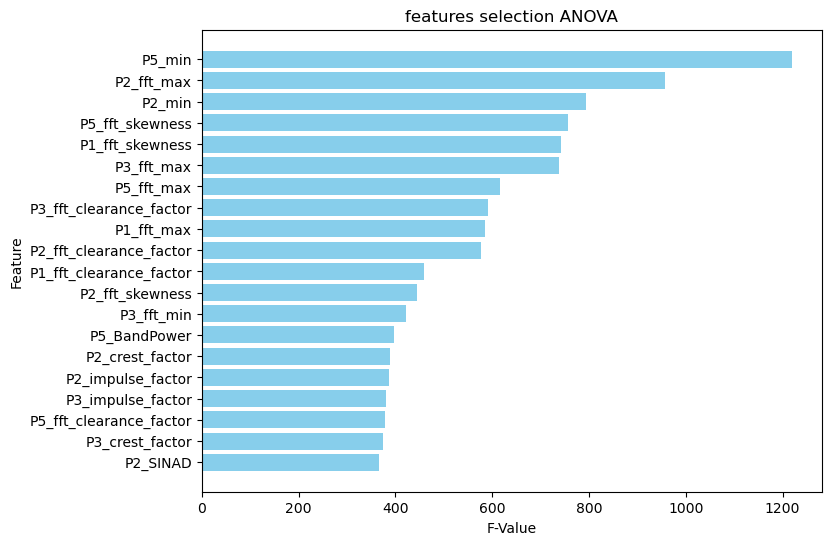

In [445]:
features_anova_train = feature_selection_anova(df_train,df_triplicato["anomaly_location"],20)


In [446]:
df_train = df_train[features_anova_train]
df_test = df_test[features_anova_train]



In [447]:
df_train = df_train[features_anova_train]


In [448]:
# df_train[105:]

In [449]:
# df_labels[105:]

In [450]:

num_locations = df_triplicato["anomaly_location"].unique()
num_locations = sorted(num_locations)
print(num_locations)

X_train, X_test, y_train, y_test = train_test_split(df_train, df_triplicato["anomaly_location"], test_size=0.3,random_state=123)

[1, 2, 3, 4, 5, 6, 7, 8]


In [451]:
y_test

522    6
485    1
530    8
524    6
482    8
467    3
511    2
523    6
488    2
513    3
468    4
503    7
496    5
499    6
529    8
460    1
502    7
501    7
509    1
473    5
483    1
521    5
Name: anomaly_location, dtype: int64

In [452]:
y_train

478    7
490    3
465    3
512    2
518    4
510    2
474    6
520    5
477    7
472    5
481    8
469    4
519    5
470    4
459    1
464    2
517    4
471    5
504    8
493    4
486    2
489    3
480    8
492    4
497    5
487    2
494    4
500    6
466    3
507    1
527    7
515    3
528    8
498    6
479    7
461    1
462    2
514    3
508    1
463    2
475    6
526    7
495    5
484    1
505    8
491    3
506    8
516    4
476    6
525    7
Name: anomaly_location, dtype: int64

In [453]:
confusion_matrices = []

map_location = {0: "Normal", 1: "BP1", 2: "BP2", 3: "BP3", 4: "BP4", 5: "BP5", 6: "BP6", 7: "BP7", 8: "BV1"}
models = []

# Definizione della grid search
param_grid = {
    'n_estimators': [50, 100, 200],

}

for location in num_locations:
    print("------------------------------------------")
    print(f"{map_location[location]}")
    print("------------------------------------------")

    y_binary_train = y_train == location

    # Definizione del modello e della grid search
    model = RandomForestClassifier(random_state=123)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, scoring='accuracy')

    # Addestramento del modello
    grid_search.fit(X_train, y_binary_train)
    
    best_model = grid_search.best_estimator_
    models.append([best_model, location])

    # Predizione sul test set
    y_pred_binary = best_model.predict(X_test)

    # Matrice di confusione e report di classificazione
    cm_train = confusion_matrix(y_binary_train, best_model.predict(X_train))
    confusion_matrices.append(cm_train)

    y_binary_test = y_test == location
    cm_test = confusion_matrix(y_binary_test, y_pred_binary)

    report = classification_report(y_binary_test, y_pred_binary)
    print(f"Classification Report for location {map_location[location]} on Test Set:")
    print(report)

    print(f"Confusion Matrix for location {map_location[location]} on Test Set:")
    print(cm_test)

predictions = []
for model in models:
    rf_model = model[0]
    pred = rf_model.predict(X_test)
    predictions.append(pred)

# print(confusion_matrices)


------------------------------------------
BP1
------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Classification Report for location BP1 on Test Set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         4

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Confusion Matrix for location BP1 on Test Set:
[[18  0]
 [ 0  4]]
------------------------------------------
BP2
------------------------------------------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Classification Report for location BP2 on Test Set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        20
        True       1.00      1.00      1.00         2

    accuracy                           1.

In [454]:
with open(f'{path_dataframes}/index_test_anomaly_task2.pkl', 'rb') as file:
    anomaly_idx = pickle.load(file)


In [455]:
anomaly_idx

array([178, 186, 193, 196, 197, 204, 209, 216, 219, 221])

In [456]:
numbers = np.repeat(np.arange(178, 224), 3)
print(numbers)
# Assegna i primi 531 elementi alla nuova colonna
df_test['Case'] = numbers[:531]

[178 178 178 179 179 179 180 180 180 181 181 181 182 182 182 183 183 183
 184 184 184 185 185 185 186 186 186 187 187 187 188 188 188 189 189 189
 190 190 190 191 191 191 192 192 192 193 193 193 194 194 194 195 195 195
 196 196 196 197 197 197 198 198 198 199 199 199 200 200 200 201 201 201
 202 202 202 203 203 203 204 204 204 205 205 205 206 206 206 207 207 207
 208 208 208 209 209 209 210 210 210 211 211 211 212 212 212 213 213 213
 214 214 214 215 215 215 216 216 216 217 217 217 218 218 218 219 219 219
 220 220 220 221 221 221 222 222 222 223 223 223]


In [457]:
df_test

,P5_min,P2_fft_max,P2_min,P5_fft_skewness,P1_fft_skewness,P3_fft_max,P5_fft_max,P3_fft_clearance_factor,P1_fft_max,P2_fft_clearance_factor,...,P2_fft_skewness,P3_fft_min,P5_BandPower,P2_crest_factor,P2_impulse_factor,P3_impulse_factor,P5_fft_clearance_factor,P3_crest_factor,P2_SINAD,Case
0,0.065920,-0.025270,0.892153,0.844304,0.869057,-0.084873,-0.029414,-0.268829,-0.007873,-0.293870,...,0.908903,1.263465,-0.983044,-0.263427,-0.259875,-0.253568,-0.501068,-0.254389,-7.4,178
1,0.048856,-0.023062,0.893218,0.846735,0.866260,-0.080733,-0.027598,-0.268223,-0.006511,-0.293247,...,0.912185,1.266684,-0.983623,-0.261053,-0.257516,-0.249483,-0.500820,-0.250047,-7.4,178
2,0.048438,-0.023046,0.893378,0.847068,0.866176,-0.080720,-0.027522,-0.268211,-0.006528,-0.293236,...,0.912242,1.266675,-0.983598,-0.261076,-0.257540,-0.249513,-0.500796,-0.250074,-7.4,178
3,0.007876,-0.190441,0.008683,0.541402,0.488657,-0.233681,-0.148347,-0.383943,-0.181819,-0.440106,...,0.564105,1.324926,-1.007667,-0.401071,-0.397250,-0.364036,-0.621609,-0.365322,-10.8,179
4,0.003821,-0.175823,0.007998,0.552495,0.504473,-0.229007,-0.145464,-0.383292,-0.177977,-0.437438,...,0.627716,1.328624,-1.006641,-0.413149,-0.409337,-0.368154,-0.621011,-0.369407,-10.8,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2.049831,-0.287145,1.285351,0.327919,0.289607,-0.307468,-0.270569,-0.357903,-0.271518,-0.430086,...,0.330182,1.197641,-0.983664,-0.447089,-0.446345,-0.402171,-0.643048,-0.399400,-8.4,222
134,2.051515,-0.287112,1.285239,0.327922,0.289617,-0.307435,-0.270553,-0.357869,-0.271484,-0.430047,...,0.330206,1.197611,-0.983643,-0.447090,-0.446346,-0.402176,-0.643012,-0.399405,-8.4,222
135,0.007586,-0.271752,0.014342,0.467282,0.459946,-0.304519,-0.235899,-0.418764,-0.263495,-0.479628,...,0.482775,1.316267,-1.028141,-0.381185,-0.376687,-0.354927,-0.688934,-0.357573,-10.8,223
136,0.003286,-0.265818,0.013266,0.485968,0.481069,-0.298781,-0.232041,-0.418260,-0.258518,-0.480459,...,0.510202,1.321367,-1.027302,-0.389898,-0.385490,-0.360582,-0.688677,-0.363134,-11.0,223


In [458]:
# new_index_values = range(178, 224)
# df_test.reset_index(drop=True, inplace=True)
# df_test.index = new_index_values

In [459]:
df_test = df_test[df_test["Case"].isin(anomaly_idx)]

In [460]:
cases = df_test["Case"].values

In [461]:
df_test = df_test.drop(columns="Case")

In [462]:
print(models)

[[RandomForestClassifier(n_estimators=50, random_state=123), 1], [RandomForestClassifier(n_estimators=50, random_state=123), 2], [RandomForestClassifier(n_estimators=50, random_state=123), 3], [RandomForestClassifier(n_estimators=50, random_state=123), 4], [RandomForestClassifier(n_estimators=50, random_state=123), 5], [RandomForestClassifier(n_estimators=50, random_state=123), 6], [RandomForestClassifier(n_estimators=50, random_state=123), 7], [RandomForestClassifier(n_estimators=50, random_state=123), 8]]


In [463]:
predictions = []
for model in models:
    print(model)
    rf_model = model[0]
    pred = rf_model.predict(df_test)
    predictions.append(pred)

[RandomForestClassifier(n_estimators=50, random_state=123), 1]
[RandomForestClassifier(n_estimators=50, random_state=123), 2]
[RandomForestClassifier(n_estimators=50, random_state=123), 3]
[RandomForestClassifier(n_estimators=50, random_state=123), 4]
[RandomForestClassifier(n_estimators=50, random_state=123), 5]
[RandomForestClassifier(n_estimators=50, random_state=123), 6]
[RandomForestClassifier(n_estimators=50, random_state=123), 7]
[RandomForestClassifier(n_estimators=50, random_state=123), 8]


In [464]:
true_indices = [np.where(arr)[0] for arr in predictions]
true_indices

[array([6, 7, 8]),
 array([ 0,  1,  2, 27, 28, 29]),
 array([15, 16, 17]),
 array([ 9, 10, 11]),
 array([24, 25, 26]),
 array([3, 4, 5]),
 array([12, 13, 14, 18, 19, 20]),
 array([], dtype=int64)]

In [465]:
predictions


[array([False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True,  True]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, False, False, False, False,
         True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, Fa

In [466]:
final_indices = []
idx = []

for array in predictions:
    indices = np.where(array == True)[0]
    idx.append(indices)
    final_indices.extend(indices)


# print(final_indices)
print(idx)
# final_indices_sorted = sorted(final_indices)

[array([6, 7, 8]), array([ 0,  1,  2, 27, 28, 29]), array([15, 16, 17]), array([ 9, 10, 11]), array([24, 25, 26]), array([3, 4, 5]), array([12, 13, 14, 18, 19, 20]), array([], dtype=int64)]


In [467]:
df_test_tmp = df_test.reset_index()

In [468]:
df_test_tmp

,index,P5_min,P2_fft_max,P2_min,P5_fft_skewness,P1_fft_skewness,P3_fft_max,P5_fft_max,P3_fft_clearance_factor,P1_fft_max,...,P1_fft_clearance_factor,P2_fft_skewness,P3_fft_min,P5_BandPower,P2_crest_factor,P2_impulse_factor,P3_impulse_factor,P5_fft_clearance_factor,P3_crest_factor,P2_SINAD
0,0,0.065920,-0.025270,0.892153,0.844304,0.869057,-0.084873,-0.029414,-0.268829,-0.007873,...,-0.338823,0.908903,1.263465,-0.983044,-0.263427,-0.259875,-0.253568,-0.501068,-0.254389,-7.4
1,1,0.048856,-0.023062,0.893218,0.846735,0.866260,-0.080733,-0.027598,-0.268223,-0.006511,...,-0.338214,0.912185,1.266684,-0.983623,-0.261053,-0.257516,-0.249483,-0.500820,-0.250047,-7.4
2,2,0.048438,-0.023046,0.893378,0.847068,0.866176,-0.080720,-0.027522,-0.268211,-0.006528,...,-0.338218,0.912242,1.266675,-0.983598,-0.261076,-0.257540,-0.249513,-0.500796,-0.250074,-7.4
3,24,0.592579,-0.255652,0.049264,0.702182,0.735586,-0.288861,-0.196697,-0.448803,-0.225115,...,-0.560232,0.772382,1.389805,-1.032659,-0.472898,-0.469524,-0.430953,-0.696645,-0.431664,-13.0
4,25,0.651294,-0.259888,0.036904,0.677571,0.718564,-0.294574,-0.202695,-0.449756,-0.229603,...,-0.560989,0.752541,1.385585,-1.031947,-0.468228,-0.464877,-0.426923,-0.698719,-0.427503,-13.0
5,26,0.651150,-0.259565,0.037499,0.677664,0.718668,-0.294518,-0.202649,-0.449807,-0.229595,...,-0.561060,0.753569,1.385741,-1.031970,-0.468563,-0.465215,-0.427112,-0.698806,-0.427690,-13.0
6,45,0.007586,-0.327714,0.527002,0.397379,0.456337,-0.349835,-0.298066,-0.425059,-0.278389,...,-0.505965,0.387193,1.280397,-1.047337,-0.345682,-0.342438,-0.317767,-0.710045,-0.318023,-12.8
7,46,0.013617,-0.325010,0.434780,0.408756,0.465394,-0.348725,-0.298520,-0.424761,-0.277374,...,-0.506053,0.403731,1.281003,-1.046964,-0.346606,-0.343359,-0.318977,-0.710155,-0.319144,-12.8
8,47,0.013356,-0.324929,0.434062,0.408714,0.465411,-0.348708,-0.298559,-0.424739,-0.277343,...,-0.506013,0.403954,1.280980,-1.046939,-0.346675,-0.343429,-0.318994,-0.710143,-0.319157,-12.8
9,54,0.007868,-0.156901,0.110812,0.608755,0.685247,-0.201754,-0.179706,-0.322882,-0.149860,...,-0.434283,0.677854,1.242724,-1.016962,-0.306915,-0.303395,-0.279298,-0.614959,-0.281033,-8.4


In [469]:

map_location_pred = { 0: "BP1", 1: "BP2", 2: "BP3", 3: "BP4", 4: "BP5", 5: "BP6", 6: "BP7", 7: "BV1"}


for index, row in df_test_tmp.iterrows():
    for i, values_pred in enumerate(idx):
        flag = True
        print("index_pred",i)

        for e in values_pred:
           
            if index == e:
                print(f"------------ Elem {e}")
                print(e)
            
             
                # if index == 2:
                    
                df_test_tmp.at[index, "Condition"] = map_location_pred[i]
                # else:
                #     df_test_tmp.at[index, "Condition"] = map_location[i]
                if(flag):
                    print("location: ",map_location_pred[i])
                    print("values_pred",values_pred)
                    flag = False

index_pred 0
index_pred 1
------------ Elem 0
0
location:  BP2
values_pred [ 0  1  2 27 28 29]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
------------ Elem 1
1
location:  BP2
values_pred [ 0  1  2 27 28 29]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
------------ Elem 2
2
location:  BP2
values_pred [ 0  1  2 27 28 29]
index_pred 2
index_pred 3
index_pred 4
index_pred 5
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 3
3
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 4
4
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 7
index_pred 0
index_pred 1
index_pred 2
index_pred 3
index_pred 4
index_pred 5
------------ Elem 5
5
location:  BP6
values_pred [3 4 5]
index_pred 6
index_pred 

In [472]:
df_test_tmp["real_case"]=cases

In [473]:
df_test_tmp = df_test_tmp.rename(columns={"index":"Case"})

In [475]:
df_test_tmp[["Case","Condition","real_case"]]

,Case,Condition,real_case
0,0,BP2,178
1,1,BP2,178
2,2,BP2,178
3,24,BP6,186
4,25,BP6,186
5,26,BP6,186
6,45,BP1,193
7,46,BP1,193
8,47,BP1,193
9,54,BP4,196
